In [148]:
# Dataclass Preparation
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from glob import glob
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import cv2
import time 
import mediapipe
from torchvision import transforms
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision import models


In [149]:
resnet = models.resnet34(pretrained=True)

/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [150]:
list(resnet.children())[:8]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [273]:
IMAGE_DIR = "/home/user/Documents/LuminEye/LuminEye/LuminEye-Iris-Center-Localization/G4_BIO_EYES"
trn_df = pd.read_csv("train_data.csv")
val_df = pd.read_csv("val_data.csv")

RESIZE_AMT = 256
BACTH_SIZE = 4

train_transforms =  A.Compose([
    A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(p=1)
])

val_transforms =  A.Compose([
    A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(p=1)
])


class CenterDataset(torch.utils.data.Dataset):
    def __init__(self,df,image_dir=IMAGE_DIR,transforms=None):
        self.image_dir = image_dir
        self.df = df
        self.image_ids = df.Image_Name.unique()
        self.transforms = transforms
        
    def __getitem__(self,ix):
        
        img_id = self.image_ids[ix]
        img_path = os.path.join(self.image_dir,img_id)
        
        img = cv2.imread(img_path)[:,:,::-1]
        
        data = self.df[self.df["Image_Name"]==img_id]
        
        
        x1 = data["X1"].values[0] * RESIZE_AMT
        y1 = data["Y1"].values[0] * RESIZE_AMT
        
        center_loc = torch.Tensor([x1,y1]).float()

        if self.transforms:
            transformed = self.transforms(image=img)
            
            image = transformed["image"]
            
    
        return image,center_loc
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_ids)


train_ds = CenterDataset(trn_df,transforms=train_transforms)
test_ds = CenterDataset(val_df,transforms=val_transforms)

trainLoader = DataLoader(train_ds, batch_size=BACTH_SIZE,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=True,drop_last=True)
testLoader = DataLoader(test_ds, batch_size=BACTH_SIZE,
	num_workers=os.cpu_count(), pin_memory=True,drop_last=True)

In [274]:
x,y = next(iter(testLoader))



In [275]:
x

tensor([[[[ 1.4440,  1.4440,  1.4440,  ..., -0.2171, -0.2171, -0.2171],
          [ 1.4440,  1.4440,  1.4440,  ..., -0.2171, -0.2171, -0.2171],
          [ 1.4440,  1.4440,  1.4440,  ..., -0.2171, -0.2171, -0.2171],
          ...,
          [ 1.4098,  1.4098,  1.4098,  ...,  0.4166,  0.4166,  0.4166],
          [ 1.4098,  1.4098,  1.4098,  ...,  0.4166,  0.4166,  0.4166],
          [ 1.4098,  1.4098,  1.4098,  ...,  0.4166,  0.4166,  0.4166]],

         [[ 0.9755,  0.9755,  0.9755,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.9755,  0.9755,  0.9755,  ..., -0.4251, -0.4251, -0.4251],
          [ 0.9755,  0.9755,  0.9755,  ..., -0.4251, -0.4251, -0.4251],
          ...,
          [ 0.9405,  0.9405,  0.9405,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.9405,  0.9405,  0.9405,  ...,  0.1001,  0.1001,  0.1001],
          [ 0.9405,  0.9405,  0.9405,  ...,  0.1001,  0.1001,  0.1001]],

         [[ 0.9145,  0.9145,  0.9145,  ..., -0.0790, -0.0790, -0.0790],
          [ 0.9145,  0.9145,  

In [276]:
features_extraction = list(resnet.children())[:8]

In [277]:
resnet_featuresEachStage = []

for i in range(len(features_extraction)):
    
    if i== 2:
        feature= features_extraction[:i+1]
        output = nn.Sequential(*feature)

        image = output(x)

        resnet_featuresEachStage.append(image)

    elif i == 3:

        image = features_extraction[i](image)

    elif i>3:

        feature_1 = features_extraction[i]
        output   = nn.Sequential(*feature_1)

        image = output(image)
        resnet_featuresEachStage.append(image)




In [278]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [279]:
len(resnet_featuresEachStage)

5

In [280]:
unnorm_batch = unnorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)


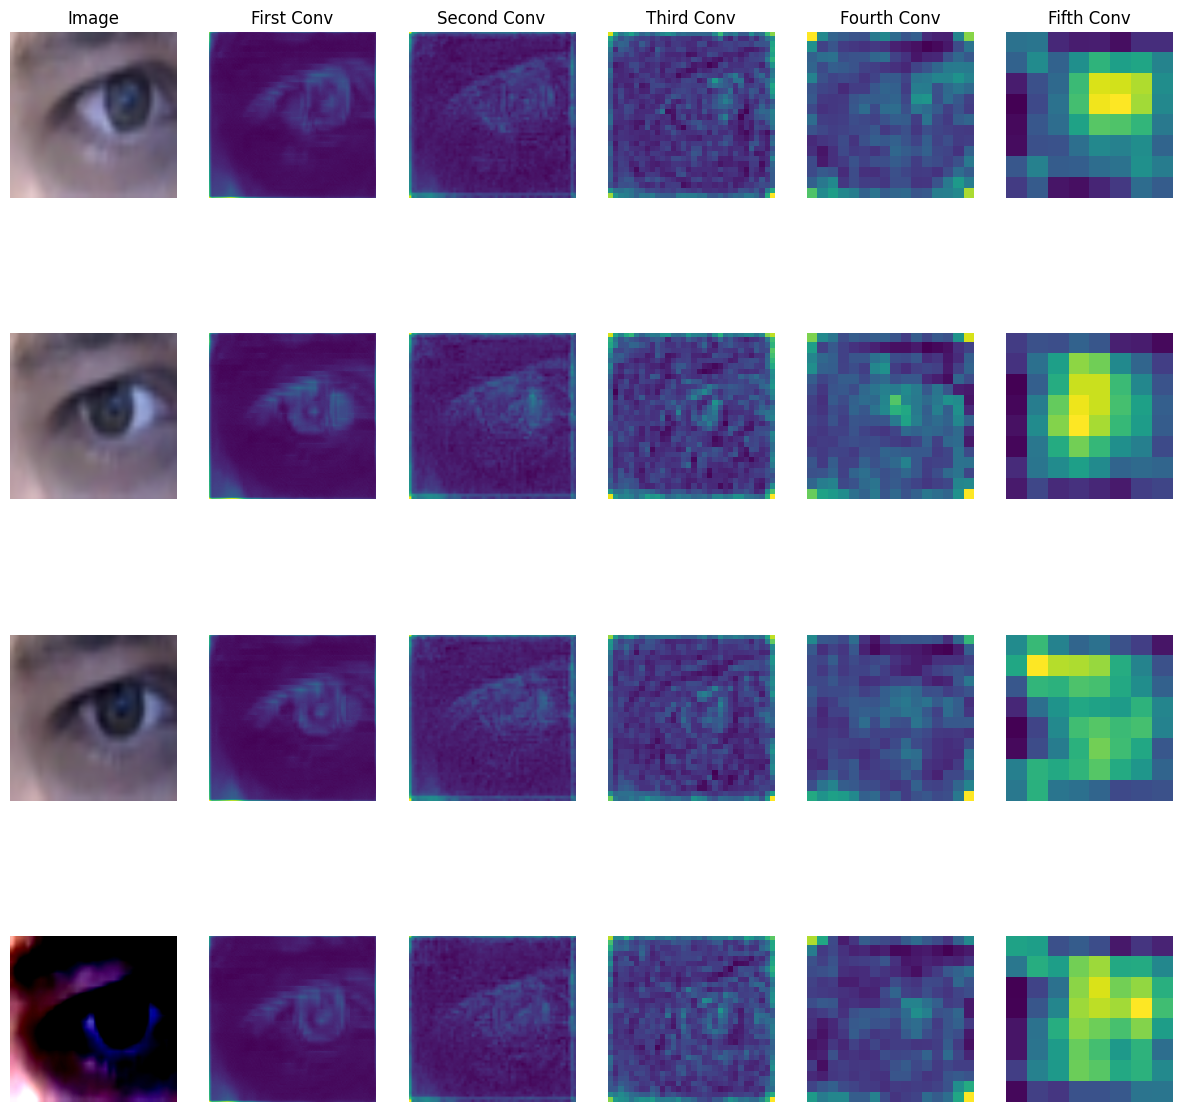

In [281]:
fig,axs = plt.subplots(x.shape[0],len(resnet_featuresEachStage)+1,figsize=(15, 15))
axs[0][0].set_title('Image')
axs[0][1].set_title('First Conv')
axs[0][2].set_title('Second Conv')
axs[0][3].set_title('Third Conv')
axs[0][4].set_title('Fourth Conv')
axs[0][5].set_title('Fifth Conv')
for num_img in range(x.shape[0]):

    img = unnorm_batch[num_img].permute(1,2,0).detach().numpy()
    axs[num_img][0].imshow(img)
    axs[num_img][0].axis('off')
    
    for each_stage in range(len(resnet_featuresEachStage)):
        

        feature_maps = resnet_featuresEachStage[each_stage]

        img_feature = feature_maps[num_img]

        # Element wise addition along batch dimenions
        summed_img = torch.sum(img_feature,dim=0).detach().numpy()

        print(summed_img .shape)

        axs[num_img][each_stage+1].imshow(summed_img)
        axs[num_img][each_stage+1].axis('off')

    